In [3]:
from clustering import Clustering,Trajectory
from utils import refactor_and_plot,display_clusters_oat
import time
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import cv2

import seq2seq
import utils as ut

from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.model_selection import train_test_split

In [2]:
c = Clustering("data/laurier/laurier.sqlite","data/laurier/laurier-homography.txt")
c.get_trajectories(pixels = 1)
trajectories = np.array([trajectory.pixel_trajectory for trajectory in c.trajectories])


In [113]:
#trajectories = trajectories[idx]

### behavior feature extraction

In [3]:
diff_x,diff_y,diff_v,diff_r = seq2seq.extract_features(trajectories)

In [4]:
features = [seq2seq.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]

In [5]:
X = seq2seq.minmax_scale_append_eos(features)

### Autoencoder

In [1]:
DATA_PATH = "data/laurier/"
DATA_BASE = "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
HOMOGRAPHY = "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

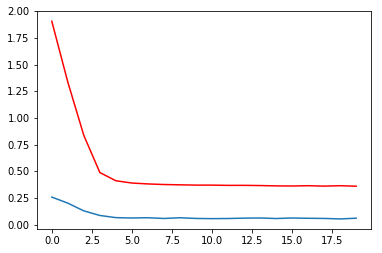

duration: 33.421394825


In [6]:
D = seq2seq.seq2seq(X)
D.to_csv(SAVE_PATH + "unified_trajectory_seq2seq.txt")

### Clustering

In [4]:
D = pd.read_csv(SAVE_PATH + "unified_trajectory_seq2seq.txt")

In [9]:
from sklearn.preprocessing import StandardScaler
import copy
std_data = copy.copy(D)
scaler = StandardScaler()
std_data[std_data.columns] = scaler.fit_transform(std_data[std_data.columns]) 

### KMeans

In [18]:
from sklearn.cluster import KMeans

nb_clusters = 4 #nb pair pour l'affichage
clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit_predict(std_data)

In [102]:
idx = [i for i,cl in enumerate(clusters) if cl != 1]

In [103]:
D = D[idx]

In [104]:
D.shape

(1563, 100)

### DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(std_data)

In [11]:
print(np.max(clusters))
count = 0
for j in clusters:
    if j == -1:
        count += 1
print(count)

14
1684


### Hierarchical

In [51]:
from sklearn.cluster import AgglomerativeClustering

clusters = AgglomerativeClustering(n_clusters=nb_clusters).fit_predict(std_data) # ou D

### Display one after the other

#### out window

In [19]:
from utils import refactor_and_plot,display_clusters_oat

display_clusters_oat(clusters,"data/laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])

#### in window

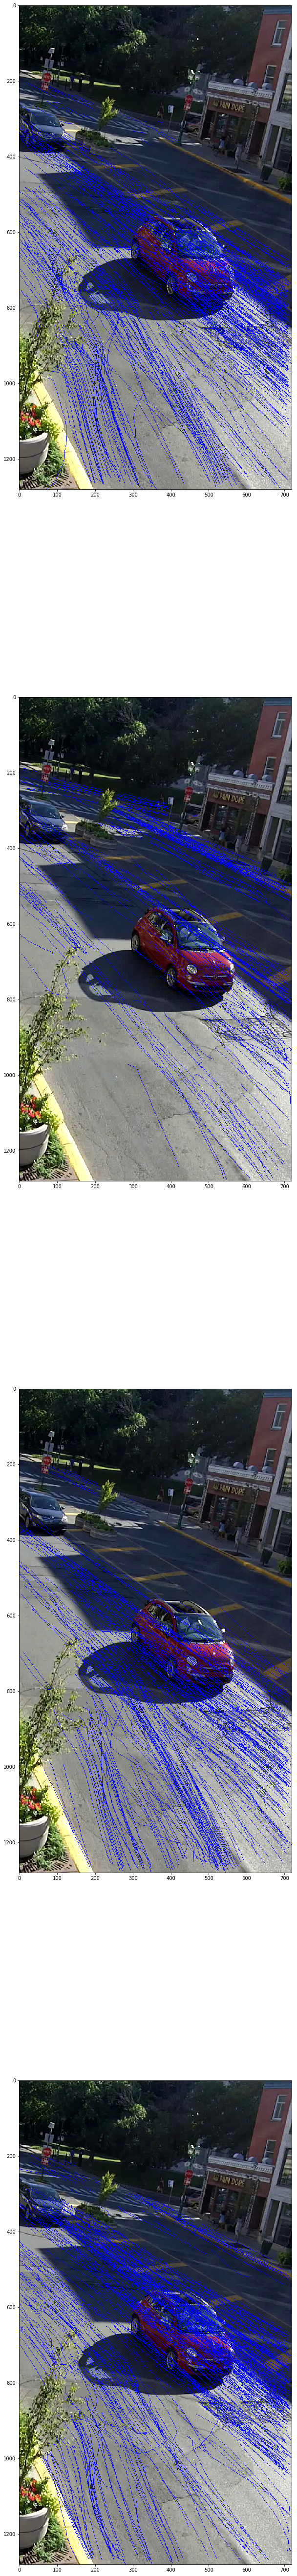

In [136]:
import matplotlib.image as mpimg

import copy

img = mpimg.imread("data/laurier/laurier.jpg")
fig = plt.figure(figsize=(10,100))

columns = 1
rows = nb_clusters

for i in range(nb_clusters):
    fig.add_subplot(rows,columns,i+1)
    img1 = copy.copy(img)
    for j,cl in enumerate(clusters):
        if cl == i:
            #img = mpimg.imread("laurier/laurier.jpg")
            
            pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
            pts = pts.reshape((-1,1,2))
            img1 = cv2.polylines(img1,[pts],False,(0,0,255)) 
    plt.imshow(img1)

plt.show()

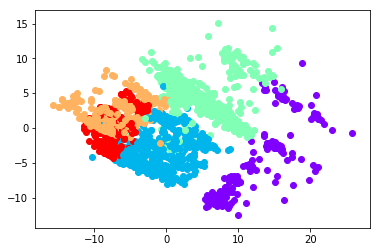

In [69]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))


for i, row in ddf.iterrows():
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()

In [35]:
from utils import refactor_and_plot,display_clusters_oat
display_clusters_oat(clusters,"laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])